# Project: Markov Simulation

#### In this project, you will write a program that simulates customer behaviour in a supermarket.

Requirements for a Supermarket Simulation
1. User Requirement
- 1.1 As a user, I want multiple customers to visit locations in the supermarket.
- 1.2 After running the simulation the output should be a CSV table similar to the initial customer data.
- 1.3 I want to run the program many times to see how dense the different sections of the supermarket are over time, how many people go to the checkout etc.
- 1.4 I want to see how dense will be croud if i increase customers
2. System Requirements
- 2.1 The customers should considered churned once they reach the checkout.
- 2.2 A customer should be implemented in it’s own class
- 2.3 The customers move to the next location based on a Monte Carlo Markov Chain.
- 2.4 The class Supermarket should manage multiple Customer objects that are currently in the market

#### The project involves the following tasks:
 - explore the data (includes pandas wrangling)
 - calculate transition probabilities (a 5x5 matrix)
 - create a customer class and implement MCMC for one customer
 - create a supermarket class that simulates multiple customers
 - visualize the supermarket
 - fill the shelves of a supermarket image
 - clean up your code

### Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import cufflinks as cf
import chart_studio.plotly as py

cf.set_config_file(world_readable=True, theme='pearl', offline=True)

cf.go_offline()

plt.rcParams['figure.figsize'] = (14,6)

### Explore the data (includes pandas wrangling)

We have 5 files with daily information. 
We have timestamp data, so we can download and concat all files in one df. Files saved in data folder

In [2]:
df_list = []
for file in os.listdir('data'):
    path='data/'+file
    day = re.sub(r'\.\w+','',file)
    df = pd.read_csv(path, delimiter=';')
    df['day'] = [day]*len(df)
    df_list.append(df)

df = pd.concat(df_list)

In [3]:
df = df.sort_values(by=['timestamp', 'customer_no'])

In [4]:
df

timestamp  customer_no  location     day
0     2019-09-02 07:03:00            1     dairy  monday
1     2019-09-02 07:03:00            2     dairy  monday
2     2019-09-02 07:04:00            3     dairy  monday
3     2019-09-02 07:04:00            4     dairy  monday
4     2019-09-02 07:04:00            5    spices  monday
...                   ...          ...       ...     ...
5120  2019-09-06 21:50:00         1500     dairy  friday
5121  2019-09-06 21:50:00         1507  checkout  friday
5122  2019-09-06 21:50:00         1508  checkout  friday
5123  2019-09-06 21:50:00         1509    drinks  friday
5124  2019-09-06 21:50:00         1510    spices  friday

[24877 rows x 4 columns]

In [5]:
df['timestamp'] = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df['time'] = df.index
# df=df.drop('Unnamed: 0', axis=1)

In [6]:
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24877 entries, 2019-09-02 07:03:00 to 2019-09-06 21:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_no  24877 non-null  int64         
 1   location     24877 non-null  object        
 2   day          24877 non-null  object        
 3   time         24877 non-null  datetime64[ns]
 4   date         24877 non-null  object        
 5   hour         24877 non-null  int64         
 6   minute       24877 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1.5+ MB


In [8]:
df.tail(10)

customer_no  location     day                time  \
timestamp                                                                
2019-09-06 21:49:00         1494    spices  friday 2019-09-06 21:49:00   
2019-09-06 21:49:00         1496     dairy  friday 2019-09-06 21:49:00   
2019-09-06 21:49:00         1503    drinks  friday 2019-09-06 21:49:00   
2019-09-06 21:49:00         1505     dairy  friday 2019-09-06 21:49:00   
2019-09-06 21:50:00         1496     fruit  friday 2019-09-06 21:50:00   
2019-09-06 21:50:00         1500     dairy  friday 2019-09-06 21:50:00   
2019-09-06 21:50:00         1507  checkout  friday 2019-09-06 21:50:00   
2019-09-06 21:50:00         1508  checkout  friday 2019-09-06 21:50:00   
2019-09-06 21:50:00         1509    drinks  friday 2019-09-06 21:50:00   
2019-09-06 21:50:00         1510    spices  friday 2019-09-06 21:50:00   

                           date  hour  minute  
timestamp                                      
2019-09-06 21:49:00  2019-09-06    21      49  
2019-09-06 21:49:00  2019-09-06    21      49  
2019-09-06 21:49:00  2019-09-06    21      49  
2019-09-06 21:49:00  2019-09-06    21      49  
2019-09-06 21:50:00  2019-09-06    21      50  
2019-09-06 21:50:00  2019-09-06    21      50  
2019-09-06 21:50:00  2019-09-06    21      50  
2019-09-06 21:50:00  2019-09-06    21      50  
2019-09-06 21:50:00  2019-09-06    21      50  
2019-09-06 21:50:00  2019-09-06    21      50

Questions:
- Nan and missing data
- shape of df
- locations
- customers
- how many locations one customer visited
- total time of one customer visit (from first location to check out)
- Calculate the total number of customers in each section
- Calculate the total number of customers in each section over time
- Display the number of customers at checkout over time
- Calculate the time each customer spent in the market
- Calculate the total number of customers in the supermarket over time.
- Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

Our customers number starts from one every day, we need to give them unique id. We have 5 days mon-fri data set

In [9]:
days = df['day'].unique()
num = 0
for day in days:
    df.loc[df['day']==day,'customer_id'] = df.loc[df['day']==day, 'customer_no'] + num
    num = num+df.loc[df['day']==day, 'customer_no'].max()

In [10]:
df=df.drop(['day','customer_no'], axis=1)

In [11]:
df.isna().sum()

location       0
time           0
date           0
hour           0
minute         0
customer_id    0
dtype: int64

In [12]:
df.location.unique() #5 locations

array(['dairy', 'spices', 'fruit', 'checkout', 'drinks'], dtype=object)

In [13]:
df.customer_id.unique() # 7445 unique customers

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 7.443e+03, 7.444e+03,
       7.445e+03])

In [14]:
df.shape

(24877, 6)

Calculate the total number of customers in each section through all period

In [15]:
df.groupby(['location'])['customer_id'].count()

location
checkout    7417
dairy       4679
drinks      3905
fruit       5122
spices      3754
Name: customer_id, dtype: int64

In [16]:
df['location'].iplot(kind='hist', xTitle='Customers Count',
                  yTitle='Locations', title='Distribution of customers through locations')

###  We will create extra columns to understand behavior of customers

In [17]:
list_customer_id = df['customer_id'].unique()

In [18]:
#Column 'next' with next visited location
for customer in list_customer_id:
    df.loc[df['customer_id']==customer, ['next']]=\
    (df.loc[df['customer_id']==customer, 'location'].shift(-1)).fillna(float('Nan'))

In [19]:
#Column 'delta' with time customer spent in each location
for customer in list_customer_id:
    df.loc[df['customer_id']==customer, ['delta']]=\
    (df.loc[df['customer_id']==customer, 'time'].shift(-1)-\
     df.loc[df['customer_id']==customer, 'time']).fillna(pd.Timedelta(seconds=0))
df['delta']=df['delta']/60000000000
    

In [20]:
#Column 'total_time_customer' with total time customer spent in the shop
for customer in list_customer_id:
    v=df.loc[df['customer_id']==customer, ['customer_id','delta']].groupby('customer_id')['delta'].sum()
    df.loc[df['customer_id']==customer, 'total_time_customer']=v[customer]

In [21]:
#Column 'step' with count of visit at curent location
for customer in list_customer_id:
    n=1
    v=[i for i in range(1,len(df.loc[df['customer_id']==customer, ['customer_id','location']])+1)]
    df.loc[df['customer_id']==customer, 'step']=v


In [22]:
#Column 'prev' with prev visited location
for customer in list_customer_id:
    df.loc[df['customer_id']==customer, ['prev']]=\
    df.loc[df['customer_id']==customer, 'location'].shift().fillna(float('Nan'))

In [23]:
#Delete all customers, who didn't reach checkout at the end of the day
for customer in list_customer_id:
    if 'checkout' not in np.array(df.loc[df['customer_id']==customer, 'location']):
        df=df[df.customer_id != customer]

In [24]:
df.shape

(24798, 11)

Number of customers, who enter new locations over time

In [25]:
df.groupby(['time', 'location'])['customer_id'].count().head()

time                 location
2019-09-02 07:03:00  dairy       2
2019-09-02 07:04:00  dairy       2
                     fruit       1
                     spices      3
2019-09-02 07:05:00  checkout    2
Name: customer_id, dtype: int64

#### SAVE FILE

In [26]:
df.to_csv('xlsx/clean_df.csv')

Customers spend 'delta' time at each location, so this calculation doesn't give us proper answer to the question how many customers are at each location over time. We will create new df with columns locations with total number of clients there over time.
To do that i used excel table.

In [27]:
df = pd.read_csv('xlsx/clean_xl_final.csv', delimiter = ';', index_col = 'timestamp')

In [28]:
df = df.iloc[1:]

In [29]:
df.head(20) 

location                 time        date  hour  minute  \
timestamp                                                                      
2019-09-02 07:03:00     dairy  2019-09-02 07:03:00  2019-09-02   7.0     3.0   
2019-09-02 07:03:00     dairy  2019-09-02 07:03:00  2019-09-02   7.0     3.0   
2019-09-02 07:04:00     dairy  2019-09-02 07:04:00  2019-09-02   7.0     4.0   
2019-09-02 07:04:00     dairy  2019-09-02 07:04:00  2019-09-02   7.0     4.0   
2019-09-02 07:04:00    spices  2019-09-02 07:04:00  2019-09-02   7.0     4.0   
2019-09-02 07:04:00    spices  2019-09-02 07:04:00  2019-09-02   7.0     4.0   
2019-09-02 07:04:00    spices  2019-09-02 07:04:00  2019-09-02   7.0     4.0   
2019-09-02 07:04:00     fruit  2019-09-02 07:04:00  2019-09-02   7.0     4.0   
2019-09-02 07:05:00  checkout  2019-09-02 07:05:00  2019-09-02   7.0     5.0   
2019-09-02 07:05:00  checkout  2019-09-02 07:05:00  2019-09-02   7.0     5.0   
2019-09-02 07:05:00     dairy  2019-09-02 07:05:00  2019-09-02   7.0     5.0   
2019-09-02 07:05:00    drinks  2019-09-02 07:05:00  2019-09-02   7.0     5.0   
2019-09-02 07:06:00  checkout  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00  checkout  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00     dairy  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00     fruit  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00    drinks  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00    spices  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00     dairy  2019-09-02 07:06:00  2019-09-02   7.0     6.0   
2019-09-02 07:06:00     fruit  2019-09-02 07:06:00  2019-09-02   7.0     6.0   

                     customer_id      next  delta  total_time_customer  step  \
timestamp                                                                      
2019-09-02 07:03:00          1.0  checkout    2.0                  2.0   1.0   
2019-09-02 07:03:00          2.0  checkout    3.0                  3.0   1.0   
2019-09-02 07:04:00          3.0  checkout    2.0                  2.0   1.0   
2019-09-02 07:04:00          4.0  checkout    4.0                  4.0   1.0   
2019-09-02 07:04:00          5.0  checkout    1.0                  1.0   1.0   
2019-09-02 07:04:00          6.0     dairy    1.0                 25.0   1.0   
2019-09-02 07:04:00          7.0    drinks    1.0                  9.0   1.0   
2019-09-02 07:04:00          8.0  checkout    3.0                  3.0   1.0   
2019-09-02 07:05:00          1.0       NaN    0.0                  2.0   2.0   
2019-09-02 07:05:00          5.0       NaN    0.0                  1.0   2.0   
2019-09-02 07:05:00          6.0    spices   12.0                 25.0   2.0   
2019-09-02 07:05:00          7.0    spices    4.0                  9.0   2.0   
2019-09-02 07:06:00          2.0       NaN    0.0                  3.0   2.0   
2019-09-02 07:06:00          3.0       NaN    0.0                  2.0   2.0   
2019-09-02 07:06:00          9.0     fruit    6.0                  7.0   1.0   
2019-09-02 07:06:00         10.0  checkout    2.0                  2.0   1.0   
2019-09-02 07:06:00         11.0  checkout    2.0                  2.0   1.0   
2019-09-02 07:06:00         12.0    drinks    1.0                  4.0   1.0   
2019-09-02 07:06:00         13.0    spices    7.0                 10.0   1.0   
2019-09-02 07:06:00         14.0  checkout    3.0                  3.0   1.0   

                       prev  checkout  dairy  drinks  fruit  spices  
timestamp                                                            
2019-09-02 07:03:00     NaN         0      1       0      0       0  
2019-09-02 07:03:00     NaN         0      2       0      0       0  
2019-09-02 07:04:00     NaN         0      3       0      0       0  
2019-09-02 07:04:00     NaN         0      4       0      0       0  
2019-09-02 07:04:00     NaN         0      4       0      0       1  
2019-09-0

In [30]:
df.to_csv('xlsx/clean_df_count.csv')

## Time clients spent in each section

In [31]:
df.loc[df['location']=='drinks', 'delta'].iplot(kind='hist', 
    xTitle='Time min', yTitle='Count', 
    title='Time client spends at one location')

<AxesSubplot:xlabel='delta', ylabel='Count'>

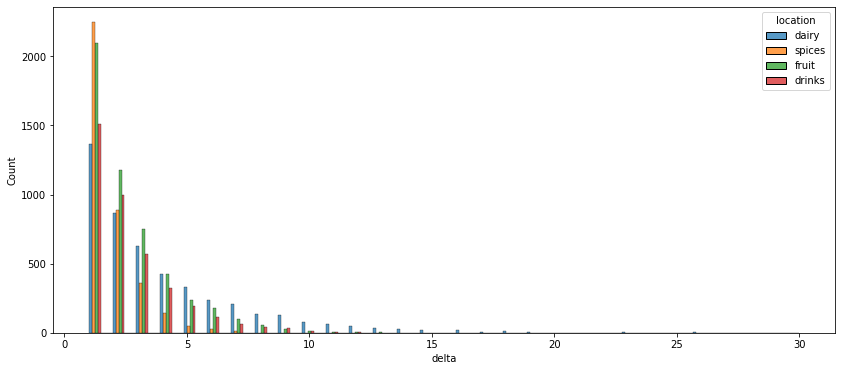

In [32]:
sns.histplot(df.loc[df['location'] != 'checkout'], x = 'delta', hue = 'location', multiple="dodge", bins = 60)

Calculate how much time customers spent in each section

In [33]:
(df.groupby('location')['delta'].sum()/60).iplot(kind='bar', xTitle='Locations',
                  yTitle='Time in hours', title='Total time customers spent at locations')

Display the number of customers at checkout over time (hide other locations on plot)

In [34]:
df[['checkout','dairy','fruit','spices','drinks','time']].groupby('time')['checkout','dairy','fruit','spices','drinks'].max().iplot(kind='bar', xTitle='Time',
                  yTitle='Customers at location', title='The number of customers at locations over time')

<ipython-input-34-620234ee9bb7>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [35]:
a=df.groupby(['date','hour','location'])['customer_id'].count().reset_index()
# b=a.pivot(index = ['date','hour'], columns='location', values='customer_id')
a.rename(columns = {'customer_id':'customer_count'}, inplace = True) 
# b

In [36]:
df[['checkout','dairy','fruit','spices','drinks','date','hour']]\
.groupby(['date','hour'])['checkout','dairy','fruit','spices','drinks']\
.mean().iplot(kind='bar', xTitle='Date and time in hours',
 yTitle='Customers at locations', 
 title='The number of customers at checkout over time per hours')
# b.iplot(kind='bar', xTitle='Date and time in hours',
#                   yTitle='Count of customers', title='Total count of customers at locations')

<ipython-input-36-0b3abdb47d00>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<AxesSubplot:xlabel='date', ylabel='customer_count'>

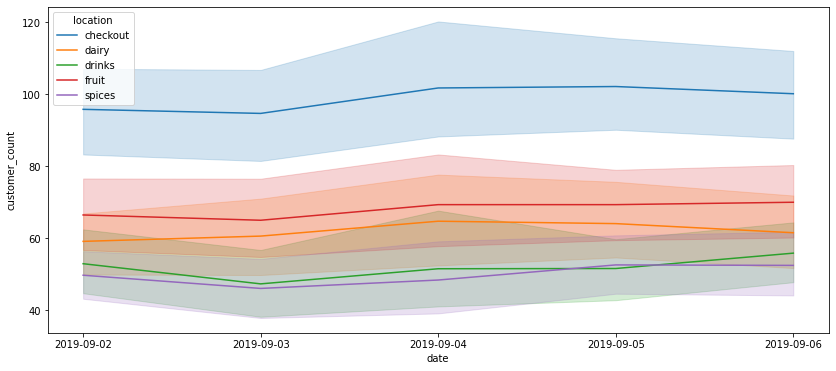

In [37]:
sns.lineplot(data=a, x='date', y='customer_count', hue='location')

In [38]:
c=(df.groupby(['date','hour','location'])['delta'].sum()/60).reset_index()
d=c.pivot(index = ['date','hour'], columns='location', values='delta')
c.rename(columns = {'delta':'time_at_location'}, inplace = True) 
d

location         checkout     dairy    drinks     fruit    spices
date       hour                                                  
2019-09-02 7.0        0.0  3.516667  2.900000  2.366667  1.216667
           8.0        0.0  4.433333  2.633333  3.300000  1.600000
           9.0        0.0  3.466667  2.783333  3.183333  1.083333
           10.0       0.0  4.150000  1.450000  2.083333  1.500000
           11.0       0.0  2.116667  1.066667  1.483333  0.916667
...                   ...       ...       ...       ...       ...
2019-09-06 17.0       0.0  4.100000  3.100000  3.583333  1.683333
           18.0       0.0  7.033333  3.683333  4.666667  2.316667
           19.0       0.0  4.866667  3.216667  4.133333  1.800000
           20.0       0.0  2.783333  2.900000  2.666667  1.733333
           21.0       0.0  1.383333  0.900000  0.966667  0.500000

[75 rows x 5 columns]

In [39]:
d.iplot(kind='bar', xTitle='Date and time in hours',
                  yTitle='Time in hours', title='Total time customers spent at locations')

Mean time clients spend at each location

<AxesSubplot:xlabel='date', ylabel='time_at_location'>

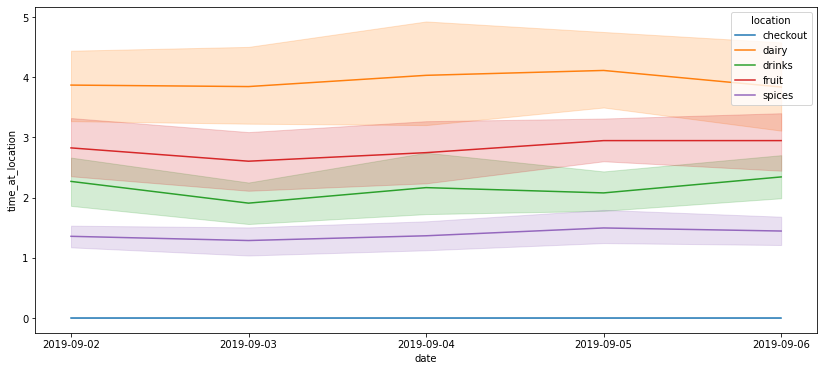

In [40]:
sns.lineplot(data=c, x='date', y='time_at_location', hue='location')

Calculate the total number of customers in the supermarket over time.

<AxesSubplot:xlabel='time'>

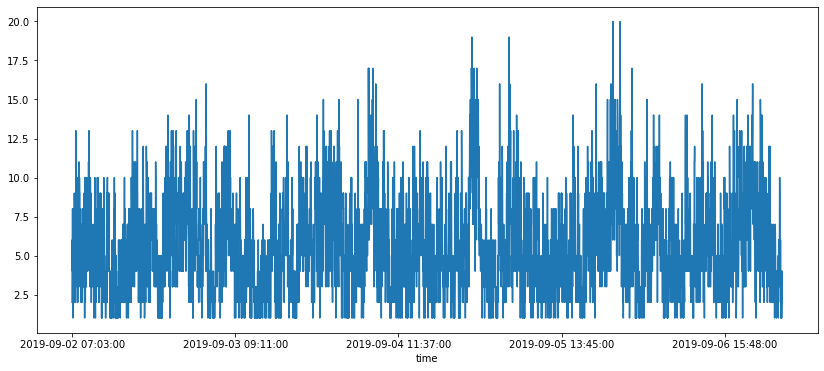

In [82]:
df.groupby(['time'])['customer_id'].count().plot()

Calculate the average time customers spent in the market

In [84]:
df.groupby('customer_id')['delta'].sum().describe()

count    7417.000000
mean        6.246191
std         6.003690
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        52.000000
Name: delta, dtype: float64

Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

In [86]:
e=df.loc[df['step']==1, ['location','next','customer_id']]
f=e.pivot(index = ['customer_id'], columns='location', values='next')   
f.iplot(kind='hist', xTitle='Location',
                  yTitle='Number of clients', title='Distribution of customers of their first visited section vs following sections')

In [87]:
df[['location','next','customer_id']].groupby('location')['location'].count()

location
checkout    7417
dairy       4651
drinks      3889
fruit       5102
spices      3739
Name: location, dtype: int64

In [88]:
df.groupby(['time'])['checkout','dairy','drinks','fruit','spices'].max().iplot(kind='hist', xTitle='number of clients per minute',
                  yTitle='Number of counts', title='Distribution of customers at each location over time')

<ipython-input-88-563491c64a0d>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Distribution of clients enter the shop

In [89]:
df.loc[df['step']==1, 'location'].iplot(kind='hist', xTitle='number of clients per minute',
                  yTitle='Number of counts', title='Distribution of customers at each location over time')